In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imghdr
import os
import tensorflow as tf
from tensorflow import keras

In [2]:
# Avoid OOM error by setting GPU memory growth limit
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

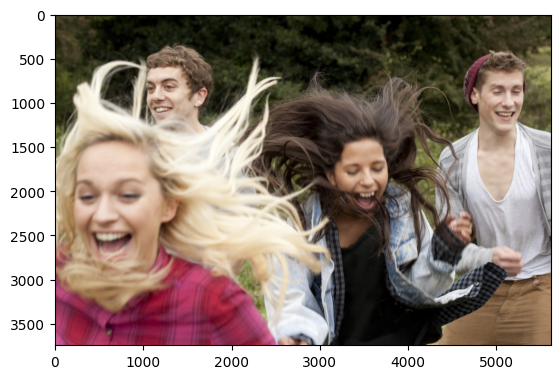

In [20]:
img = cv2.imread('happy.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [67]:
# Removing dodgy from the data directory
path = "data"
img_formats = ["jpg", "jpeg", "png", "bmp"]

for folder in os.listdir(path):
    for image in os.listdir(os.path.join(path, folder)):
        image_path = os.path.join(path, folder, image)
        try:
            img = cv2.imread(image_path)
            frmt = imghdr.what(image_path)
            if frmt not in img_formats:
                print("Get the hell out'a here")
                print(image_path)
                os.remove(image_path)
        except:
            print("bruh")
            print(image_path)

In [3]:
# Building data pipeline for our images
data = keras.utils.image_dataset_from_directory('data')

Found 357 files belonging to 2 classes.


In [57]:
# Creating batches of our dataset
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [58]:
batch[0].shape

(32, 256, 256, 3)

In [59]:
# Class 1 = Sad Peaple & Class 0 = Happy Peaple
batch[1]

array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0])

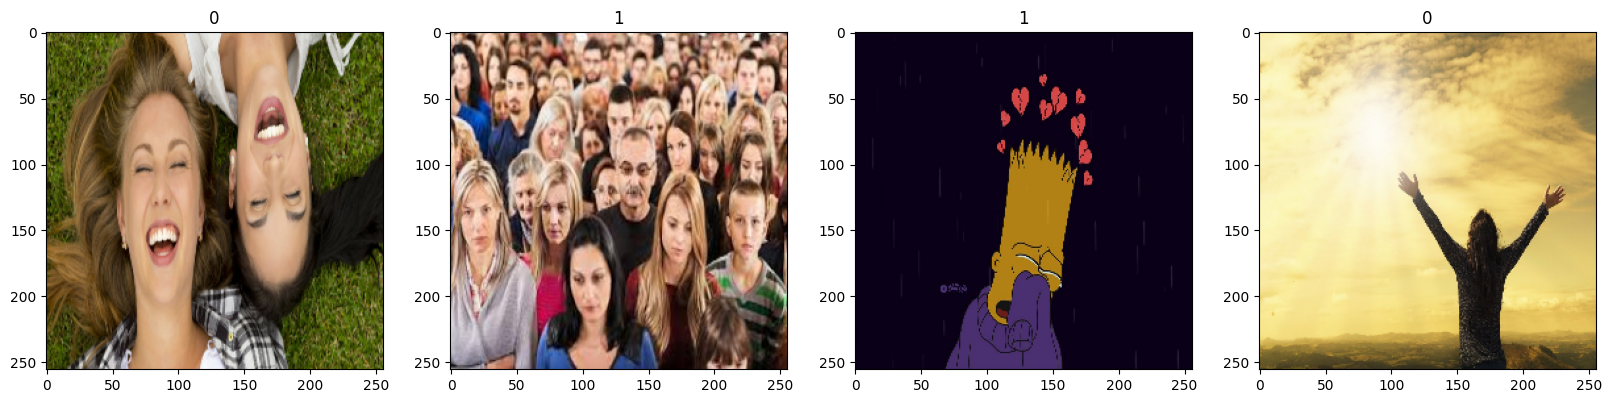

In [60]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for index, img in enumerate(batch[0][:4]):
    ax[index].imshow(img.astype(int))
    ax[index].title.set_text(batch[1][index])

In [4]:
# Scaling data between 0 and 1
data = data.map(lambda x,y: (x/255, y))

In [5]:
data.as_numpy_iterator().next()[0].max()

1.0

In [6]:
len(data)

12

In [7]:
# Specifying train, validation, and test sizes 
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2) + 1 
test_size = int(len(data) * 0.1)

In [8]:
train_size + test_size + val_size

12

In [9]:
# Splitting dataset to train, validation, and test datasets
train = data.take(train_size)
validation = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [10]:
len(validation)

3

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [36]:
# Building sequential cnn model with 3 convolution and maxpooling layers following by 2 dense layers
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [37]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 30, 30, 16)      

In [38]:
logdir = "logs"
tensor_callbacks = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
# Fitting train and validation datas to the model
hist = model.fit(train, epochs=20, validation_data=validation, callbacks=[tensor_callbacks])

Epoch 1/20
8/8 [==============================] - 4s 319ms/step - loss: 0.6890 - accuracy: 0.5273 - val_loss: 0.6292 - val_accuracy: 0.6458
Epoch 2/20
8/8 [==============================] - 4s 301ms/step - loss: 0.5713 - accuracy: 0.7422 - val_loss: 0.4991 - val_accuracy: 0.7917
Epoch 3/20
8/8 [==============================] - 4s 316ms/step - loss: 0.4840 - accuracy: 0.7617 - val_loss: 0.4304 - val_accuracy: 0.7917
Epoch 4/20
8/8 [==============================] - 4s 307ms/step - loss: 0.3149 - accuracy: 0.8945 - val_loss: 0.3687 - val_accuracy: 0.8542
Epoch 5/20
8/8 [==============================] - 4s 307ms/step - loss: 0.3177 - accuracy: 0.8711 - val_loss: 0.2516 - val_accuracy: 0.9271
Epoch 6/20
8/8 [==============================] - 4s 312ms/step - loss: 0.2506 - accuracy: 0.9141 - val_loss: 0.1935 - val_accuracy: 0.9271
Epoch 7/20
8/8 [==============================] - 4s 299ms/step - loss: 0.1742 - accuracy: 0.9453 - val_loss: 0.1181 - val_accuracy: 0.9583
Epoch 8/20
8/8 [====

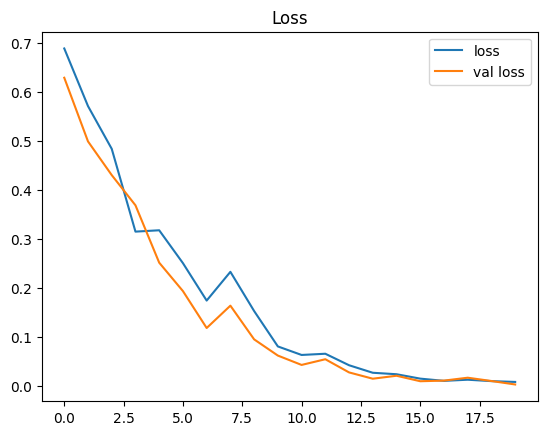

In [40]:
# Plotting loss differences between train and validation datas
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val loss")
plt.title("Loss")
plt.legend()
plt.show()

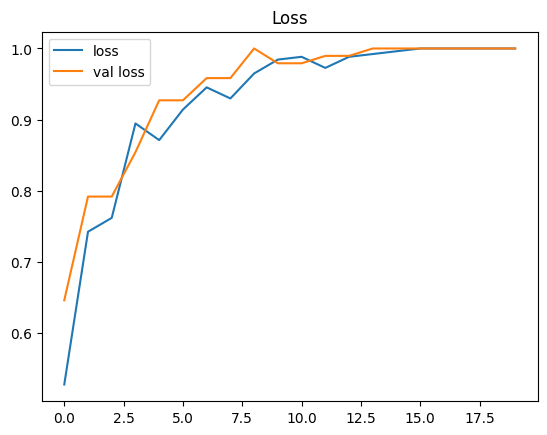

In [69]:
# Plotting accuracy differences between train and validation datas
plt.plot(hist.history["accuracy"], label="loss")
plt.plot(hist.history["val_accuracy"], label="val loss")
plt.title("Loss")
plt.legend()
plt.show()

In [42]:
model.evaluate(test)

1/1 [==============================] - 2s 2s/step - loss: 0.0015 - accuracy: 1.0000


[0.0014617249835282564, 1.0]

In [70]:
from tensorflow.keras.metrics import Precision, Recall
pre = Precision()
rec = Recall()

for X, y in test.as_numpy_iterator():
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)

1/1 [==============================] - 0s 19ms/step


In [52]:
print(f"Precision: {pre.result().numpy()}")
print(f"Recall: {rec.result().numpy()}")

Precision: 1.0
Recall: 1.0


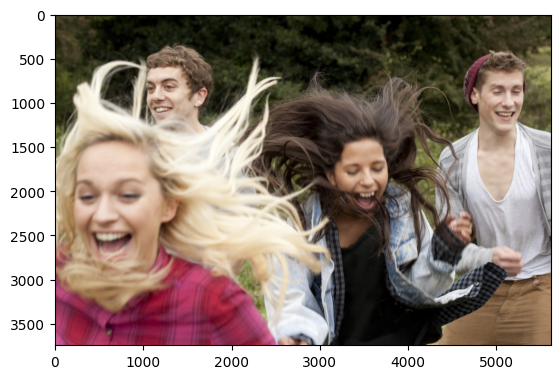

In [54]:
happy_img = cv2.imread("happy.jpg")
sad_img = cv2.imread("sad.jpg")

plt.imshow(cv2.cvtColor(happy_img, cv2.COLOR_BGR2RGB))
plt.show()

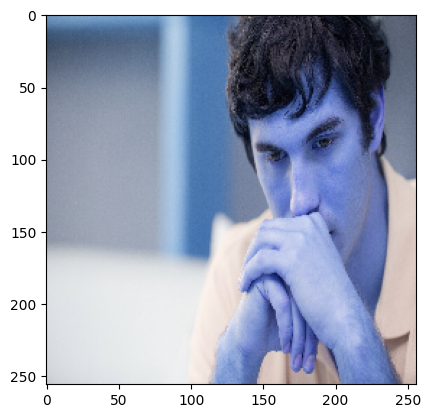

In [65]:
resized_img = tf.image.resize(sad_img, (256,256))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [66]:
pred = model.predict(np.expand_dims(resized_img / 255, 0))

1/1 [==============================] - 0s 18ms/step


In [67]:
if pred > 0.5:
    print("Sad")
else:
    print("Happy")

Sad
